In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [5]:
# Load data - Adjust the file path as needed
data = pd.read_csv('D:\Practice.csv', parse_dates=['settlement_date'], dayfirst=True)

In [7]:
# Preprocess the data
data.fillna(0, inplace=True)
data.set_index('settlement_date', inplace=True)  # Set the date as the index


In [17]:
# Feature Engineering - Add important factors
data['TOTAL_EMBEDDED_GENERATION'] = data['embedded_wind_generation'] + data['embedded_solar_generation']
data['NET_NATIONAL_DEMAND'] = data['nd'] + data['TOTAL_EMBEDDED_GENERATION']
data['TOTAL_INTERCONNECTOR_FLOW'] = (
    data['ifa_flow'] + data['ifa2_flow'] + data['moyle_flow'] +
    data['east_west_flow'] + data['nemo_flow'] + data['nsl_flow']
)


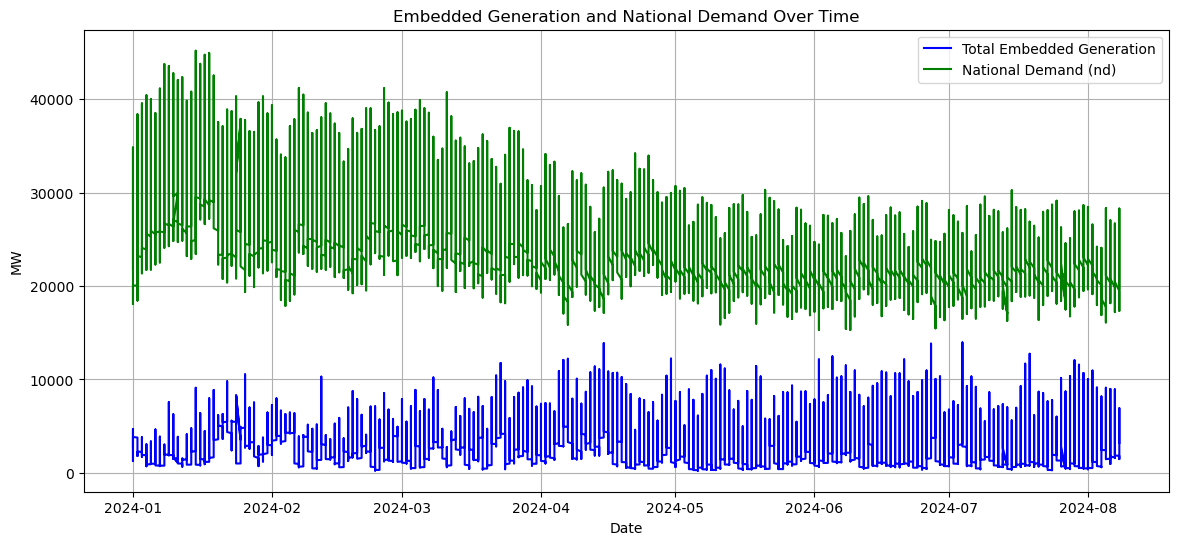

In [19]:
# Visualize the energy generation data
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['TOTAL_EMBEDDED_GENERATION'], label='Total Embedded Generation', color='blue')
plt.plot(data.index, data['nd'], label='National Demand (nd)', color='green')
plt.xlabel('Date')
plt.ylabel('MW')
plt.title('Embedded Generation and National Demand Over Time')
plt.legend()
plt.grid(True)
plt.show()


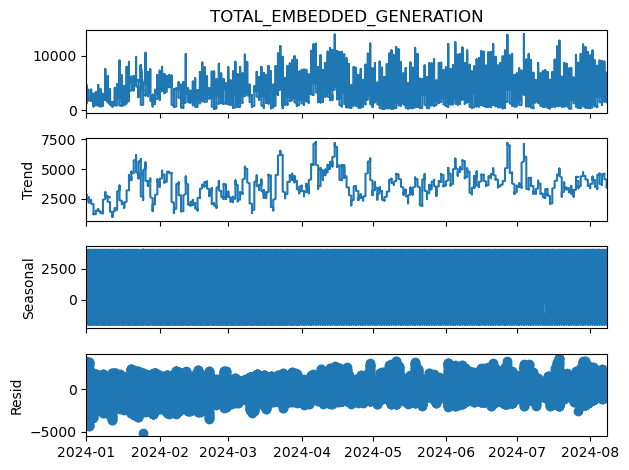

In [21]:
# Decompose the time series data to observe trend and seasonality
decompose_result = seasonal_decompose(data['TOTAL_EMBEDDED_GENERATION'], model='additive', period=48)  # Assuming half-hourly data
decompose_result.plot()
plt.show()


In [23]:
# Forecasting using SARIMA model
# Splitting data into training and testing
train_data = data['TOTAL_EMBEDDED_GENERATION'][:-100]  # Last 100 points as test data
test_data = data['TOTAL_EMBEDDED_GENERATION'][-100:]



In [25]:
# Define the SARIMA model (seasonal orders can be adjusted based on data analysis)
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 48))  # Seasonal order can be changed based on seasonality detected
sarima_model = model.fit(disp=False)

C:\Users\96cra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\96cra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\96cra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\96cra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
# Forecast future values
forecast = sarima_model.forecast(steps=len(test_data))


C:\Users\96cra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\96cra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
# Evaluate the model
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


MAE: 866.60, RMSE: 1444.28


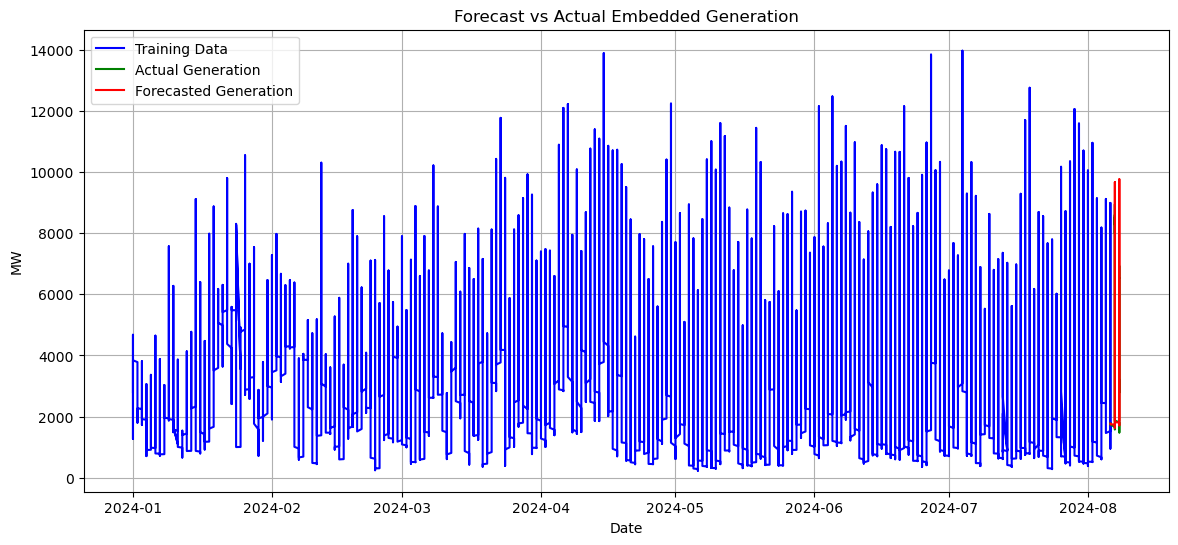

In [34]:
# Plot the forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Generation', color='green')
plt.plot(test_data.index, forecast, label='Forecasted Generation', color='red')
plt.xlabel('Date')
plt.ylabel('MW')
plt.title('Forecast vs Actual Embedded Generation')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Future Forecasting - Extend the forecast to predict further into the future
future_steps = 48 * 7  # Forecast for one week ahead
future_forecast = sarima_model.get_forecast(steps=future_steps)
future_forecast_ci = future_forecast.conf_int()


C:\Users\96cra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\96cra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


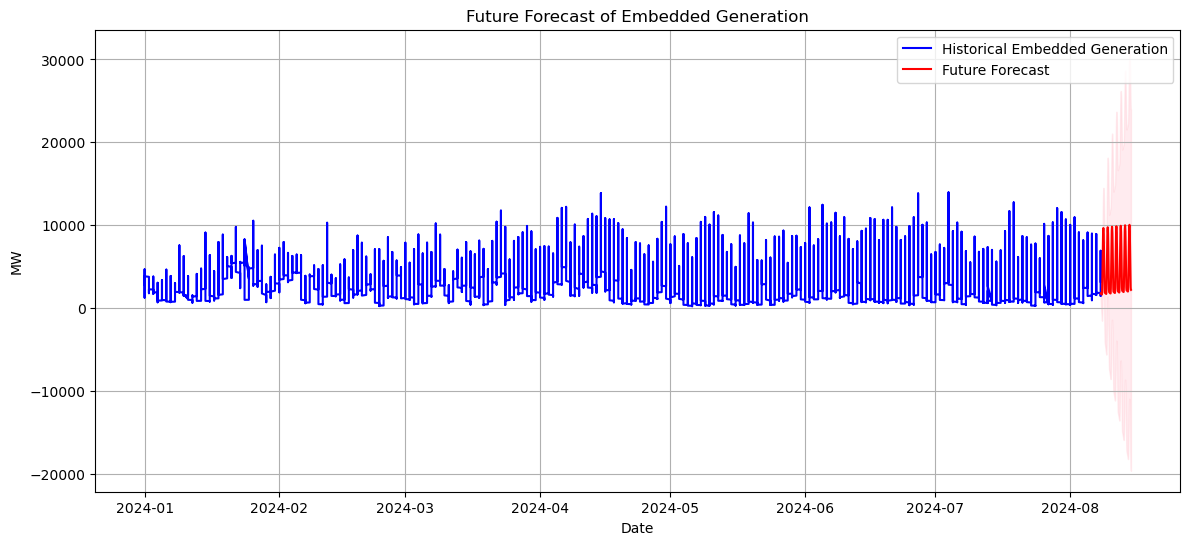

In [33]:
# Plot future predictions
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['TOTAL_EMBEDDED_GENERATION'], label='Historical Embedded Generation', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=future_steps, freq='30min'), future_forecast.predicted_mean, 
         label='Future Forecast', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=future_steps, freq='30min'),
                 future_forecast_ci.iloc[:, 0], future_forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('MW')
plt.title('Future Forecast of Embedded Generation')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\96cra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\96cra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\96cra\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


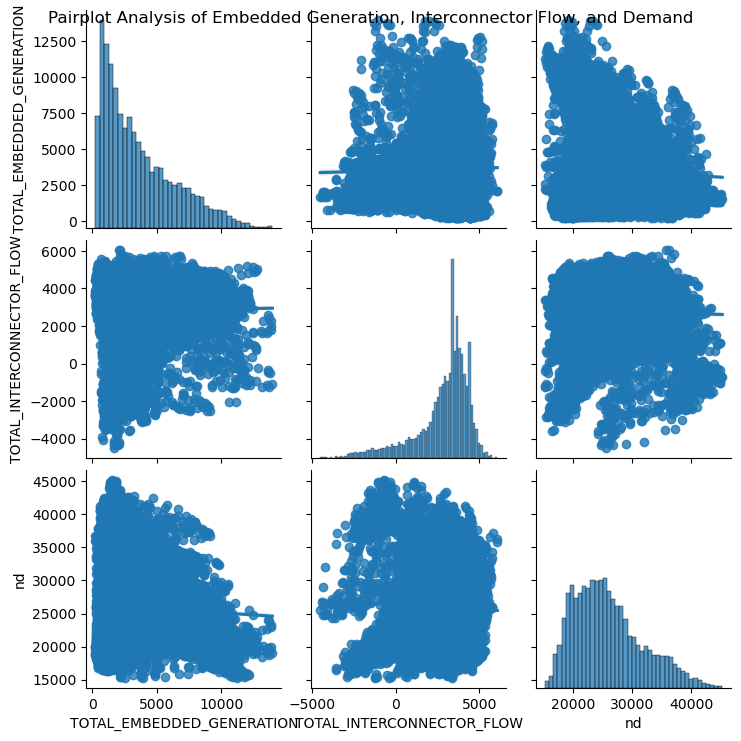

In [41]:
# Analysis of Other Factors
# Analyze the relationship between generation and other factors such as interconnector flows
sns.pairplot(data[['TOTAL_EMBEDDED_GENERATION', 'TOTAL_INTERCONNECTOR_FLOW', 'nd']], kind='reg')
plt.suptitle('Pairplot Analysis of Embedded Generation, Interconnector Flow, and Demand')
plt.show()


In [45]:
# Correlation Analysis
corr_matrix = data[['TOTAL_EMBEDDED_GENERATION', 'TOTAL_INTERCONNECTOR_FLOW', 'nd']].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

print("\n--- Insights ---")
print("1. The SARIMA model forecasts embedded generation with reasonable accuracy, highlighting potential future trends.")
print("2. There is a notable correlation between interconnector flows and embedded generation, suggesting external dependencies.")
print("3. Forecasting results can be used for planning and managing future energy demand and generation requirements.")


Correlation Matrix:
                           TOTAL_EMBEDDED_GENERATION  \
TOTAL_EMBEDDED_GENERATION                   1.000000   
TOTAL_INTERCONNECTOR_FLOW                   0.019204   
nd                                         -0.061372   

                           TOTAL_INTERCONNECTOR_FLOW        nd  
TOTAL_EMBEDDED_GENERATION                   0.019204 -0.061372  
TOTAL_INTERCONNECTOR_FLOW                   1.000000 -0.040356  
nd                                         -0.040356  1.000000  

--- Insights ---
1. The SARIMA model forecasts embedded generation with reasonable accuracy, highlighting potential future trends.
2. There is a notable correlation between interconnector flows and embedded generation, suggesting external dependencies.
3. Forecasting results can be used for planning and managing future energy demand and generation requirements.
